https://www.kaggle.com/code/alperenkaran/spotify-artist-network-using-spotipy-and-networkx

# Part 1: Load the libraries

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
!pip install spotipy
clear_output()

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

## Part 1.1 Access to Spotify API

In [3]:
client_id = "d254f8fb33f04f3387783254d645fe0a"
client_secret =  "3d49d97709bb40c79833aae56ec78dda"

credmanager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=credmanager)

# Part 2: Demonstrating some features of Spotify API

Below I will show some features of the spotify api. We can search for an artist, a track, or a playlist. In the below example, I will search 'Taylor Swift'.

Then, I will demonstrate how Spotify allows us to see related artists of an artist.

## Part 2.1 Searching Taylor Swift

`sp.search('Taylor Swift', type='artist)['artists']['items']` will return a list of artists that matches the search query, that is, `Taylor Swift`.

Let's select the first element from that list, and look inside.

In [4]:
taylor_search = sp.search('Taylor Swift', type='artist')['artists']['items'][0]
taylor_search

{'external_urls': {'spotify': 'https://open.spotify.com/artist/06HL4z0CvFAxyc27GXpf02'},
 'followers': {'href': None, 'total': 106430450},
 'genres': ['pop'],
 'href': 'https://api.spotify.com/v1/artists/06HL4z0CvFAxyc27GXpf02',
 'id': '06HL4z0CvFAxyc27GXpf02',
 'images': [{'height': 640,
   'url': 'https://i.scdn.co/image/ab6761610000e5ebe672b5f553298dcdccb0e676',
   'width': 640},
  {'height': 320,
   'url': 'https://i.scdn.co/image/ab67616100005174e672b5f553298dcdccb0e676',
   'width': 320},
  {'height': 160,
   'url': 'https://i.scdn.co/image/ab6761610000f178e672b5f553298dcdccb0e676',
   'width': 160}],
 'name': 'Taylor Swift',
 'popularity': 100,
 'type': 'artist',
 'uri': 'spotify:artist:06HL4z0CvFAxyc27GXpf02'}

It is somewhat messy, isn't it? For example, for this notebook, we don't need the height and width of Taylor Swift's images. In fact, I don't need the images at all.

Let's create a function which will give the most important features of an artist as a dictionary.

Remember that if `d` is a dictionary, `d.get(k, val)` gives `d[k]` if `k` is a key of `d`. Otherwise, it returns `val`.

In [5]:
def artist_features(spotify_search_result):
    result = {
        'artist_name': spotify_search_result.get('name', 'artist_name_not_available'),
        'artist_id': spotify_search_result.get('id', 'artist_id_not_available'),
        'artist_popularity': spotify_search_result.get('popularity', 0),
        'artist_first_genre': (spotify_search_result.get('genres', ['genre_not_available']) + ['genre_not_available'])[0],
        'artist_n_followers': spotify_search_result.get('followers', {}).get('total', 0)
    }
    return result

In [6]:
taylor_features = artist_features(taylor_search)
taylor_features

{'artist_name': 'Taylor Swift',
 'artist_id': '06HL4z0CvFAxyc27GXpf02',
 'artist_popularity': 100,
 'artist_first_genre': 'pop',
 'artist_n_followers': 106430450}

It looks much better now, doesn't it?

## Part 2.2 Related artists

Now let's look at the related artists of Taylor Swift. For this, we will use `sp.artist_related_artists` function, and Taylor Swift's id.

In [7]:
taylors_related_artists = sp.artist_related_artists(taylor_features['artist_id'])['artists']

print('Taylor has', len(taylors_related_artists), 'related artists. The first one is given below. \n\n')

artist_features(taylors_related_artists[0])

Taylor has 20 related artists. The first one is given below. 




{'artist_name': 'Selena Gomez',
 'artist_id': '0C8ZW7ezQVs4URX5aX7Kqx',
 'artist_popularity': 82,
 'artist_first_genre': 'pop',
 'artist_n_followers': 48716612}

So, apparently, Taylor's first related artist is Demi Lovato!

To my knowledge, every artist on Spotify has 20 related artists (I have never seen otherwise).

# Part 3: A very brief tutorial on `networkx` library

1. `G = nx.Graph()` creates an undirected empty graph.

2. `G.add_node(nodename)` creates a node identified by its nodename. 

    For example, `G.add_node('Taylor Swift')` creates a node.
        

3. `G.add_node(nodename, att1=val1, att2=val2)` creates a node with given attributes. 

    For example, `G.add_node('Taylor Swift', 'artist_popularity'=100, 'artist_n_followers'=47402350)` creates a node with two attributes.
    
4.  Instead of writing the attributes one by one, you can pass a dictionary `d` like `G.add_node(nodename, **d)`

    For example, if `d = {'artist_popularity':100, 'artist_n_followers':47402350}`, then `G.add_node('Taylor Swift, **d)` creates the same node in 3rd bullet point.
    
5.  `G.add_edge(nodename1, nodename2)` creates an edge between nodes `nodename1` and `nodename2`. If these nodes didn't exist, they're created automatically.

    

# Part 4: Create a graph

We can create an undirected graph by assigning each artist to a node. An edge is created whenever an artist is related with the other.

We will only choose an artist if `artist_popularity` is large enough.

In [8]:
G = nx.Graph() # create an empty graph

popularity_threshold = 80 # if an artist have a lower popularity, it won't be in our graph.

## Part 4.1 Add some initial nodes to the graph

We start with a list of artist names. We begin by adding them to our graph (if they're sufficiently popular).

In [9]:
artists_name_list = ['Taylor Swift', 'Adele', 'Beyonce', 'Michael Jackson', 'Michael Buble', 'Ed Sheeran', 'Norah Jones', 
                     'Beatles', 'Ella Fitzgerald', 'Elton John', 'Shakira', 'Lady Gaga', 'Ariana Grande', 'Stevie Wonder', 
                     'Billie Eilish', 'Dua Lipa', 'Mariah Carey', 'Jennifer Lopez']

print('There are', len(artists_name_list), 'artists in the initial list.')

There are 18 artists in the initial list.


Each node will have a number of attributes. These will be the features created by the `artist_features` function. 

We will have one more attribute called `related_found`. When an artist's related artists have not been found yet, the attribute will be `False`, otherwise it will be `True`.

In [10]:
for name in artists_name_list:
    search = sp.search(name, type='artist')['artists']['items'][0]
    this_artist = artist_features(search)
    
    if this_artist['artist_popularity'] >= popularity_threshold:
        G.add_node(this_artist['artist_name'], **this_artist, related_found=False)
    else:
        print(name, 'is not a popular artist, we do not add it to our graph.')

Michael Buble is not a popular artist, we do not add it to our graph.
Norah Jones is not a popular artist, we do not add it to our graph.
Ella Fitzgerald is not a popular artist, we do not add it to our graph.
Stevie Wonder is not a popular artist, we do not add it to our graph.
Mariah Carey is not a popular artist, we do not add it to our graph.
Jennifer Lopez is not a popular artist, we do not add it to our graph.


Oh no! But I like Norah Jones a lot! Unfortunately, she won't be in the artist network :(

## Part 4.2 Adding edges and more nodes to our graph

For every node (artist) in the graph, we will find its neighbors (related artists), unless it has already been found.

Once we find the related artists, we will also find their related artists. And so on.

We will also add an edge, when an artist is related with another artist.

We will stop when either there are no other artists left, or the number of artists in the network exceeds 1000.

**Question:** If an artist has 20 related artists, what is the possible minimum and maximum number of neighbors of a node? (Check the last cell for the answer)

In [11]:
dummy = 0

while dummy == 0:
    l = len(G) # number of nodes in the graph currently
    
    for x in list(G): # iterate each node
        if G.nodes[x]['related_found'] == False: # then we need to find its related artists
            relateds = sp.artist_related_artists(G.nodes[x]['artist_id'])['artists']
            relateds = [artist_features(r) for r in relateds]
            relateds_names = [r['artist_name'] for r in relateds]
            G.nodes[x]['related_found'] = True # it was False, but now we found its related artists
            
            for rname, rdict in zip(relateds_names, relateds):
                if rdict['artist_popularity'] >= popularity_threshold:
                    
                    if rname in G: # node already in G
                        pass # do nothing
                    
                    else:
                        G.add_node(rname, **rdict, related_found=False) # we added a new node, we don't know its relateds yet
                        clear_output(wait=True)
                        print('The graph has', len(G), 'nodes now.')
                        
                    G.add_edge(x, rname) # we add an edge between x and its related rname
                    
    if len(G) == l or len(G) > 1000: # number of nodes didn't change or graph grew too large
        dummy = 1 # break the while loop
        print('Done.')

The graph has 175 nodes now.
Done.


# Part 5: Analysis and Visualization

First let's look at how many connected components the graph has.

In [12]:
# connected components
n_connected = nx.number_connected_components(G)
print('The graph has', n_connected, 'connected components.')

The graph has 2 connected components.


Now we investigate the degree distributions. 

By looking at the graph below, we can say that more than 20 nodes had a degree (number of neighbors) of exactly 3.

Also, there are two nodes with degree 24.

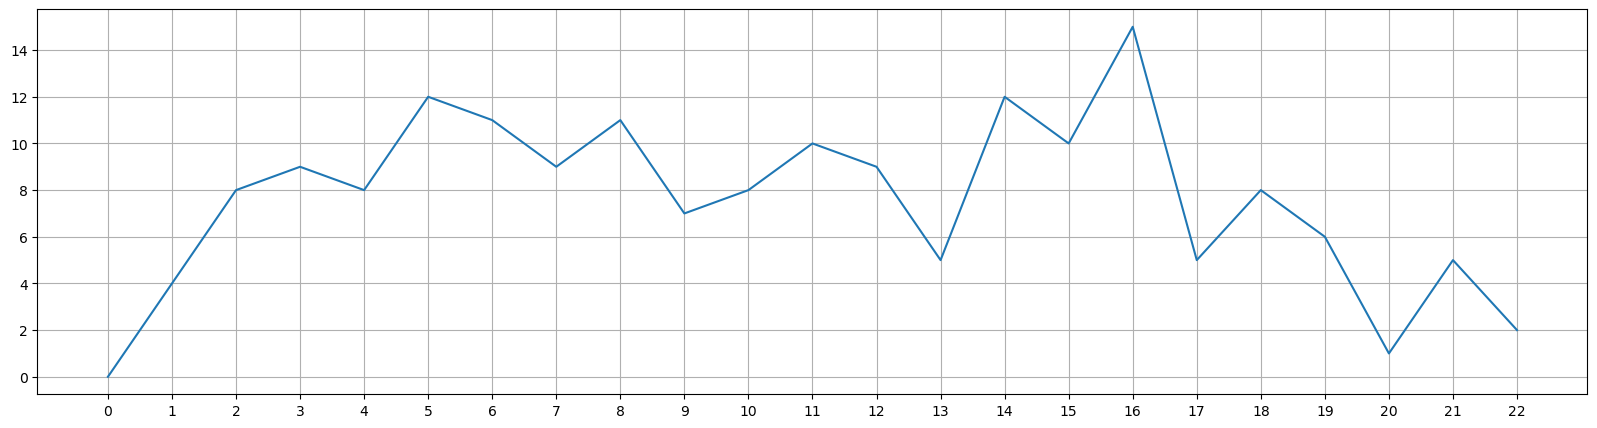

In [13]:
plt.figure(figsize=(20,5))
degree_hist = nx.degree_histogram(G)
plt.plot(degree_hist)
plt.xticks(np.arange(0,len(degree_hist)))
plt.yticks(np.arange(0,max(degree_hist)+1,2))
plt.grid()
plt.show()

/opt/mamba/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


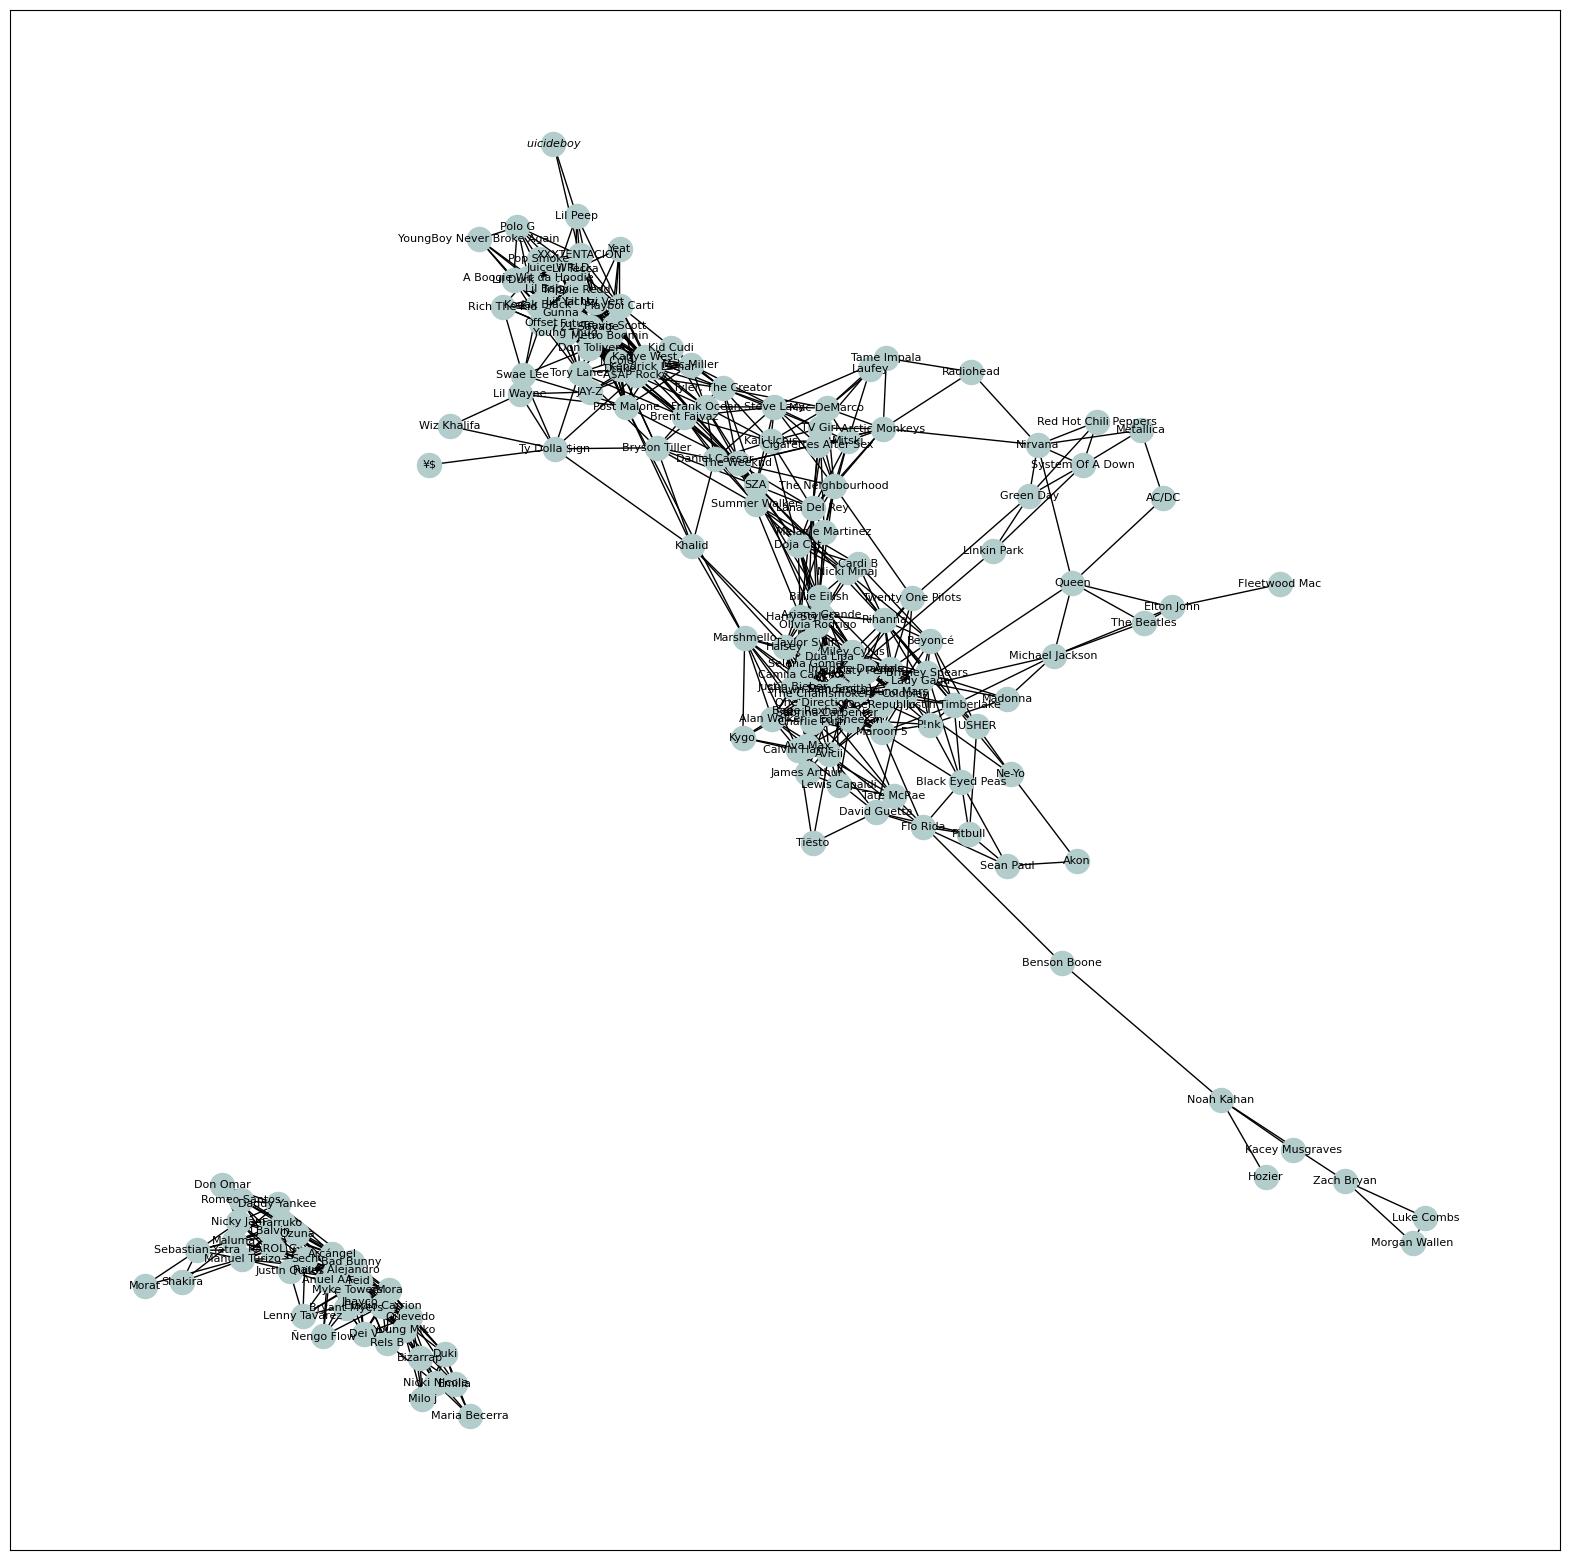

In [14]:
np.random.seed(0)
plt.figure(figsize=(20,20))
nx.draw_networkx(G, with_labels=True, node_color=(.7,.8,.8), font_size=8)

**Interpretation:** Obviously there are 3 connected components. One of them is not significant, contains only two artists (Shakira and Julieta Venegas). Also, there are some bridges connecting large clusters of nodes. For instance, if the edge between Meghan Trainor and Becky G didn't exist, the large cluster would split into two clusters.

**Answer to the previously asked question:** The minimum is zero. An artist can be popular, but all its related artists can be unpopular. There is no maximum. An artist can be a related artist of infinitely many other popular artists.